In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


## CGAN

In [56]:
def weights_init(m):
    """Initialize parameters/weights in GAN."""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    return

class CondGenerator(torch.nn.Module):
    def __init__(self, num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding):
        super().__init__()
        self.num_class = num_class
        self.latent_dim = latent_dim
        if one_hot_encoding:
            self.embedding_dim = num_class
        else:
            self.embedding_dim = embedding_dim
            self.label_embedding = nn.Embedding(num_class, embedding_dim)
        self.one_hot_encoding = one_hot_encoding

        self.label_channel = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=embedding_dim,
                out_channels=128,
                kernel_size=3,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.noise_channel = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=latent_dim,
                out_channels=128,
                kernel_size=3,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.G = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=channel_dim, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, z, y):
        """The forward function should return batch of images."""
        z = z.reshape(-1, self.latent_dim, 1, 1)
        if self.one_hot_encoding:
            y = F.one_hot(y, num_classes=self.num_class).float()
        else:
            y = self.label_embedding(y)
        y = self.label_channel(y.reshape(-1, self.embedding_dim, 1, 1))
        z = self.noise_channel(z)
        x = torch.cat((z, y), dim=1)
        x = self.G(x)
        return x


class CondDiscriminator(torch.nn.Module):
    def __init__(self, num_class, channel_dim, embedding_dim, one_hot_encoding):
        super().__init__()
        self.num_class = num_class
        self.channel_dim = channel_dim
        if one_hot_encoding:
            self.embedding_dim = num_class
        else:
            self.embedding_dim = embedding_dim
            self.label_embedding = nn.Embedding(num_class, embedding_dim)
        self.one_hot_encoding = one_hot_encoding

        self.label_channel = nn.Sequential(
            nn.Conv2d(
                in_channels=embedding_dim,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(0.2),
        )
        self.img_channel = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_dim,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )
        self.D = nn.Sequential(
            # half of the channels comes from the image, and the other half is from the label
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=2,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=256,
                out_channels=1,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        """The forward function should return the scores."""
        if self.one_hot_encoding:
            y = F.one_hot(y, num_classes=self.num_class).float()
        else:
            y = self.label_embedding(y)
        y = y[:, :, None, None].repeat(1, 1, 28, 28)
        y = self.label_channel(y)
        x = self.img_channel(x)
        x = torch.concat((x, y), dim=1)
        p = self.D(x)
        return p


class CDCGAN(object):
    def __init__(
        self, num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding, epochs, lr, device
    ):
        self.G = (
            CondGenerator(num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding)
            .apply(weights_init)
            .to(device)
        )
        self.D = (
            CondDiscriminator(num_class, channel_dim, embedding_dim, one_hot_encoding)
            .apply(weights_init)
            .to(device)
        )
        self.loss = nn.BCELoss()

        self.d_optimizer = torch.optim.Adam(
            self.D.parameters(), lr=lr, betas=(0.5, 0.999)
        )
        self.g_optimizer = torch.optim.Adam(
            self.G.parameters(), lr=lr, betas=(0.5, 0.999)
        )

        self.num_class = num_class
        self.one_hot_encoding = one_hot_encoding
        self.embedding_dim = embedding_dim
        self.channel_dim = channel_dim
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.lr = lr
        self.device = device

    def train(self, train_loader, verbose_period=2):
        for epoch in range(self.epochs):
            total_d_loss = 0
            total_g_loss = 0
            num_batches = 0
            verbose = (epoch % verbose_period) == 0
            with tqdm(train_loader, unit="batch", disable=not verbose) as bar:
                bar.set_description(f"Epoch {epoch}")
                for images, y in bar:
                    batch_size = images.size(0)
                    # Step 1: Train discriminator
                    z = torch.randn((batch_size, self.latent_dim)).to(self.device)

                    real_labels = torch.ones(batch_size)
                    fake_labels = torch.zeros(batch_size)

                    images, y = images.to(self.device), y.reshape(-1).to(self.device).long()

                    real_labels, fake_labels = real_labels.to(
                        self.device
                    ), fake_labels.to(self.device)

                    # Compute the BCE Loss using real images
                    real_scores = self.D(images, y)
                    real_scores = torch.squeeze(real_scores)
                    d_loss_real = self.loss(real_scores, real_labels)

                    # Compute the BCE Loss using fake images
                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)
                    d_loss_fake = self.loss(fake_scores, fake_labels)

                    # Optimize discriminator
                    d_loss = d_loss_real + d_loss_fake
                    self.D.zero_grad()
                    d_loss.backward()
                    # max log(D(x)) + log(1 - D(G(z))) <=> min -[ log(D(x)) + log(1 - D(G(z))) ]
                    self.d_optimizer.step()

                    # Step 2: Train Generator
                    z = torch.randn(batch_size, self.latent_dim).to(self.device)

                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)
                    g_loss = self.loss(fake_scores, real_labels)

                    self.D.zero_grad()
                    self.G.zero_grad()
                    g_loss.backward()
                    # min log(1 - D(G(z))) => min -[ log(D(G(z))) ]
                    self.g_optimizer.step()

                    # update bar
                    num_batches += 1
                    total_d_loss += d_loss.item()
                    total_g_loss += g_loss.item()
                    bar.set_postfix(
                        d_loss=float(total_d_loss / num_batches),
                        g_loss=float(total_g_loss / num_batches),
                    )
            if total_d_loss / num_batches < 1e-3 or total_g_loss / num_batches > 8:
                print(
                    f"Discriminator loss is too small and generator loss is too high at epoch:{epoch}, " +
                    "which indicate a potential saturation problem."
                )
                print("Now, re-initialize and re-train...")
                self.__init__(
                    self.num_class,
                    self.channel_dim,
                    self.latent_dim,
                    self.embedding_dim,
                    self.one_hot_encoding,
                    self.epochs,
                    self.lr,
                    self.device,
                )
                self.train(train_loader, verbose_period=verbose_period)
                return
        return

    def generate_img(self, number_of_images, class_label, channel_dim):
        samples = (
            self.G(
                torch.randn((number_of_images, self.latent_dim)).to(
                    self.device
                ),
                (class_label * torch.ones(number_of_images)).long().to(self.device),
            )
            .detach()
            .cpu()
            .reshape(-1, channel_dim, 28, 28)
        )
        samples = samples * 0.5 + 0.5
        return samples


## CWGAN

In [55]:
def gradient_penalty(D, real_images, image_labels, fake_images, device):
    """Computes the gradient penalty loss for WGAN"""
    N, C, H, W = real_images.shape
    alpha = torch.randn((N, 1, 1, 1)).repeat(1, C, H, W).to(device)
    # get X_hat
    interpolated_images = real_images * alpha + fake_images * (1 - alpha)
    interpolated_scores = D(interpolated_images, image_labels)
    # get the gradient D(X_hat)
    gradients = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=interpolated_scores,
        grad_outputs=torch.ones_like(interpolated_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    # compute the penalty
    gradients = gradients.reshape(N, -1)
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return penalty


class CondWGenerator(torch.nn.Module):
    def __init__(self, num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding):
        super().__init__()
        self.num_class = num_class
        self.latent_dim = latent_dim
        if one_hot_encoding:
            self.embedding_dim = num_class
        else:
            self.embedding_dim = embedding_dim
            self.label_embedding = nn.Embedding(num_class, embedding_dim)
        self.one_hot_encoding = one_hot_encoding

        self.label_channel = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=embedding_dim,
                out_channels=128,
                kernel_size=3,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.noise_channel = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=latent_dim,
                out_channels=128,
                kernel_size=3,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.G = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=channel_dim, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, z, y):
        """The forward function should return batch of images."""
        z = z.reshape(-1, self.latent_dim, 1, 1)
        if self.one_hot_encoding:
            y = F.one_hot(y, num_classes=self.num_class).float()
        else:
            y = self.label_embedding(y)
        y = self.label_channel(y.reshape(-1, self.embedding_dim, 1, 1))
        z = self.noise_channel(z)
        x = torch.cat((z, y), dim=1)
        x = self.G(x)
        return x


class CondWDiscriminator(torch.nn.Module):
    def __init__(self, num_class, channel_dim, embedding_dim, one_hot_encoding):
        super().__init__()
        self.num_class = num_class
        self.channel_dim = channel_dim
        if one_hot_encoding:
            self.embedding_dim = num_class
        else:
            self.embedding_dim = embedding_dim
            self.label_embedding = nn.Embedding(num_class, embedding_dim)
        self.one_hot_encoding = one_hot_encoding

        self.label_channel = nn.Sequential(
            nn.Conv2d(
                in_channels=embedding_dim,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(0.2),
        )
        self.img_channel = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_dim,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )
        self.D = nn.Sequential(
            # half of the channels comes from the image, and the other half is from the label
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=2,
                padding=0,
                bias=False,
            ),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=256,
                out_channels=1,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Flatten(),
        )

    def forward(self, x, y):
        """The forward function should return the scores."""
        if self.one_hot_encoding:
            y = F.one_hot(y, num_classes=self.num_class).float()
        else:
            y = self.label_embedding(y)
        y = y[:, :, None, None].repeat(1, 1, 28, 28)
        y = self.label_channel(y)
        x = self.img_channel(x)
        x = torch.concat((x, y), dim=1)
        p = self.D(x)
        return p


class CWDCGAN(object):
    def __init__(
        self,
        num_class,
        channel_dim,
        latent_dim,
        embedding_dim,
        one_hot_encoding,
        reg_lambda,
        n_critic,
        epochs,
        lr,
        device,
    ):
        self.G = (
            CondWGenerator(num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding)
            .apply(weights_init)
            .to(device)
        )
        self.D = (
            CondWDiscriminator(num_class, channel_dim, embedding_dim, one_hot_encoding)
            .apply(weights_init)
            .to(device)
        )

        self.d_optimizer = torch.optim.Adam(
            self.D.parameters(), lr=lr, betas=(0.5, 0.999)
        )
        self.g_optimizer = torch.optim.Adam(
            self.G.parameters(), lr=lr, betas=(0.5, 0.999)
        )

        self.num_class = num_class
        self.one_hot_encoding = one_hot_encoding
        self.embedding_dim = embedding_dim
        self.channel_dim = channel_dim
        self.latent_dim = latent_dim
        self.reg_lambda = reg_lambda
        self.n_critic = n_critic
        self.epochs = epochs
        self.lr = lr
        self.device = device

    def train(self, train_loader, verbose_period=2):
        for epoch in range(self.epochs):
            total_d_loss = 0
            total_g_loss = 0
            num_batches = 0
            verbose = (epoch % verbose_period) == 0
            with tqdm(train_loader, unit="batch", disable=not verbose) as bar:
                bar.set_description(f"Epoch {epoch}")
                for images, y in bar:
                    batch_size = images.size(0)
                    images, y = images.to(self.device), y.to(self.device).reshape(-1).long()
                    # Step 1: Train discriminator with (n_critic) iters
                    for _ in range(self.n_critic):
                        # Generate noise
                        z = torch.randn((batch_size, self.latent_dim)).to(self.device)

                        # Compute the BCE Loss using real images
                        real_scores = self.D(images, y)
                        real_scores = torch.squeeze(real_scores)

                        # Compute the BCE Loss using fake images
                        fake_images = self.G(z, y)
                        fake_scores = self.D(fake_images, y)
                        fake_scores = torch.squeeze(fake_scores)

                        # Compute the regularization term
                        gp = gradient_penalty(D=self.D, real_images=images, image_labels=y, fake_images=fake_images, device=self.device)
                        # Optimize discriminator
                        # max [ D(x) - D(G(z)) ] => min -[ D(x) - D(G(z)) ] + regularization
                        d_loss = - (torch.mean(real_scores) - torch.mean(fake_scores)) + self.reg_lambda * gp

                        # Optimize discriminator
                        self.D.zero_grad()
                        d_loss.backward(retain_graph=True)
                        self.d_optimizer.step()

                    # Step 2: Train Generator
                    z = torch.randn(batch_size, self.latent_dim).to(self.device)

                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)

                    # min [ - D(G(z)) ]
                    g_loss = -torch.mean(fake_scores)

                    # Optimize generator
                    self.D.zero_grad()
                    self.G.zero_grad()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # update bar
                    num_batches += 1
                    total_d_loss += d_loss.item()
                    total_g_loss += g_loss.item()
                    bar.set_postfix(
                        d_loss=float(total_d_loss / num_batches),
                        g_loss=float(total_g_loss / num_batches),
                    )
        return

    def generate_img(self, number_of_images, class_label, channel_dim):
        samples = (
            self.G(
                torch.randn((number_of_images, self.latent_dim)).to(
                    self.device
                ),
                (class_label * torch.ones(number_of_images)).long().to(self.device),
            )
            .detach()
            .cpu()
            .reshape(-1, channel_dim, 28, 28)
        )
        samples = samples * 0.5 + 0.5
        return samples

In [4]:
%%capture
!pip install medmnist

In [5]:
import medmnist
from medmnist import INFO, Evaluator

%matplotlib inline

In [6]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [7]:
print(f"n_channels: {n_channels}")
print(f"n_classes: {n_classes}")

n_channels: 3
n_classes: 8


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, root="/content/")
test_dataset = DataClass(split='test', transform=data_transform, download=download, root="/content/")

BATCH_SIZE = 128
# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


100%|██████████| 35461855/35461855 [00:00<00:00, 96735754.30it/s] 


Using downloaded and verified file: /content/bloodmnist.npz


In [10]:
print(train_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /content/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0


In [11]:
# label_dict = {
#     0: 'bladder',
#     1: 'femur-left',
#     2: 'femur-right',
#     3: 'heart',
#     4: 'kidney-left',
#     5: 'kidney-right',
#     6: 'liver',
#     7: 'lung-left',
#     8: 'lung-right',
#     9: 'pancreas',
#     10: 'spleen'
# }

# label_dict = {
#     0: "normal",
#     1: "pneumonia",
# }

label_dict = {
    0: 'basophil',
    1: 'eosinophil',
    2: 'erythroblast',
    3: 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
    4: 'lymphocyte',
    5: 'monocyte',
    6: 'neutrophil',
    7: 'platelet'
}

In [13]:
# class frequencies


0: basophil - 852
1: eosinophil - 2181
2: erythroblast - 1085
3: immature granulocytes(myelocytes, metamyelocytes and promyelocytes) - 2026
4: lymphocyte - 849
5: monocyte - 993
6: neutrophil - 2330
7: platelet - 1643


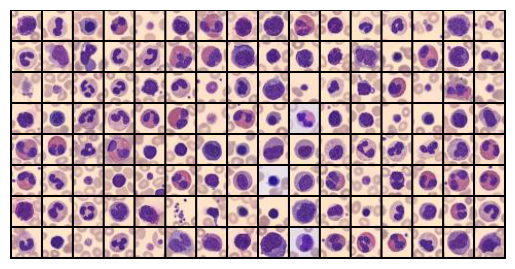

In [41]:
img_batch, label_batch = next(iter(train_loader))
img_batch = img_batch * 0.5 + 0.5
plt.imshow(
        torch.permute(
            make_grid(img_batch, nrow=16, padding=2), (1,2,0))
    )
plt.axis("off")
plt.show()

In [54]:
make_grid(img_batch, nrow=16, padding=2).shape

torch.Size([3, 242, 482])

### Pneumonia grid imgs

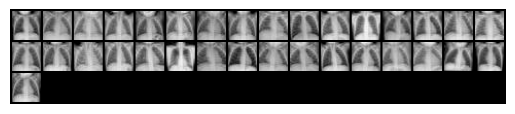

In [ ]:
plt.imshow(
        torch.permute(
            make_grid(img_batch[(1 - label_batch).reshape(-1).nonzero().reshape(-1)],
                      nrow=16, padding=2), (1,2,0))
    )
plt.axis("off")
plt.show()

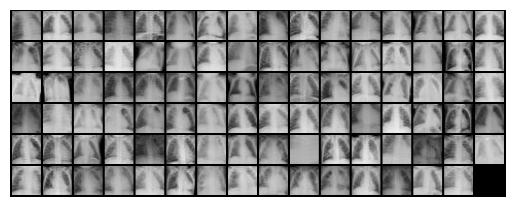

In [ ]:
plt.imshow(
        torch.permute(
            make_grid(img_batch[label_batch.reshape(-1).nonzero().reshape(-1)],
                      nrow=16, padding=2), (1,2,0))
    )
plt.axis("off")
plt.show()

## Train

In [75]:
# model = CDCGAN(
#     num_class=11,
#     channel_dim=1,
#     latent_dim=64,
#     embedding_dim=64,
#     one_hot_encoding=False,
#     epochs=20,
#     lr=2e-4,
#     device=device
# )

model_wgan = CWDCGAN(
    num_class=8,
    channel_dim=3,
    latent_dim=32,
    embedding_dim=4,
    one_hot_encoding=False,
    reg_lambda=10,
    n_critic=5,
    epochs=20,
    lr=1e-4,
    device=device
)


In [76]:
# model.train(train_loader=train_loader, verbose_period=2)
model_wgan.train(train_loader, verbose_period=2)

Epoch 18: 100%|██████████| 94/94 [00:13<00:00,  6.88batch/s, d_loss=-3.51, g_loss=30.2]


0: basophil - 852


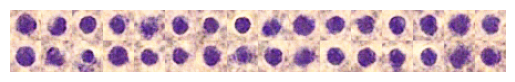

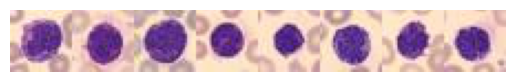

1: eosinophil - 2181


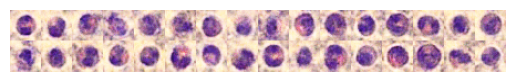

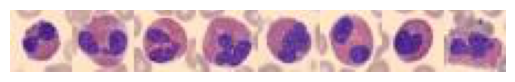

2: erythroblast - 1085


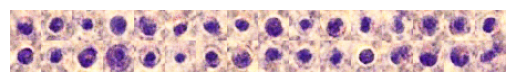

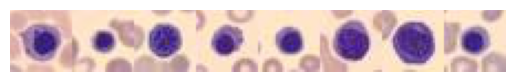

3: immature granulocytes(myelocytes, metamyelocytes and promyelocytes) - 2026


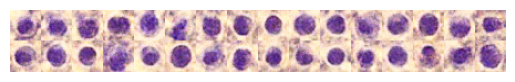

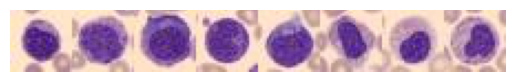

4: lymphocyte - 849


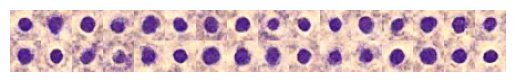

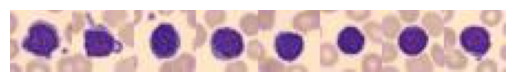

5: monocyte - 993


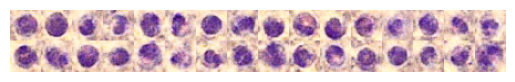

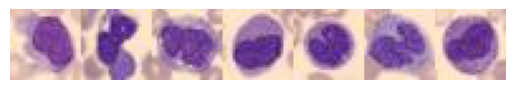

6: neutrophil - 2330


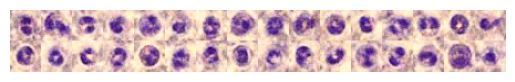

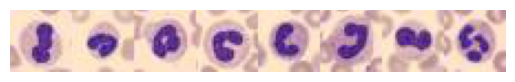

7: platelet - 1643


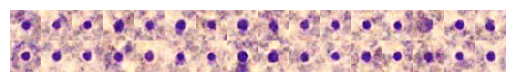

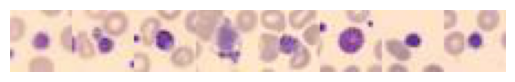

In [79]:
freqs = np.bincount(train_dataset.labels.reshape(-1))
for i in range(n_classes):
    print(f"{i}: {label_dict[i]} - {freqs[i]}")
    samples = model_wgan.generate_img(32, i, 3)
    plt.imshow(
        torch.permute(make_grid(samples, nrow=16, padding=0), (1,2,0)),
        # cmap="gray"
    )
    plt.axis("off")
    plt.show()

    idx = torch.where(label_batch == i, 1, 0).reshape(-1).nonzero().reshape(-1)
    real = img_batch[idx][:8]
    plt.imshow(
        torch.permute(make_grid(real, nrow=8, padding=0), (1,2,0)),
        # cmap="gray"
    )
    plt.axis("off")
    plt.show()
